In [ ]:
import os
import pickle
import numpy as np
import pandas as pd
import nest_asyncio
from datasets import Dataset
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from langchain_groq import ChatGroq
from ragas import evaluate, RunConfig
from langchain_huggingface import HuggingFaceEmbeddings
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_similarity,
    answer_correctness,
)

load_dotenv()

api_key = os.getenv('GROQ_API_KEY')

models = ['llama3-70b-8192', 'llama3-8b-8192', 'mixtral-8x7b-32768', 'gemma-7b-it', 'gemma2-9b-it']
metrics = [answer_relevancy, faithfulness, context_recall, context_precision, answer_similarity, answer_correctness]

In [ ]:
llm = ChatGroq(groq_api_key=api_key, model_name="llama3-8b-8192", temperature=0)

In [ ]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [ ]:
scores_dict = {'model': []}
for metric in metrics:
    scores_dict[metric.name] = []

nest_asyncio.apply()

for model in models:
    with open(f'/data/{model}.pkl', 'rb') as pickle_file:
        loaded_data_samples = pickle.load(pickle_file)

    scores_dict['model'].append(model)
    for metric in metrics:
        dataset = Dataset.from_dict(loaded_data_samples)
        score = evaluate(dataset, metrics=[metric], llm = llm, embeddings = embeddings, run_config = RunConfig(timeout=180, max_retries=20, max_wait=120, max_workers=16))

        scores_dict[metric.name].append(np.round(score[metric.name], 3))

scores_df = pd.DataFrame(scores_dict)

In [7]:
scores_df.head()

,model,answer_relevancy,faithfulness,context_recall,context_precision,answer_similarity,answer_correctness
0,llama3-70b-8192,0.890,0.605,1.0,1.0,0.713,0.645
1,llama3-8b-8192,0.750,0.467,1.0,1.0,0.605,0.519
2,mixtral-8x7b-32768,0.872,0.536,1.0,1.0,0.704,0.613
3,gemma-7b-it,0.157,0.392,1.0,1.0,0.595,0.473
4,gemma2-9b-it,0.407,0.700,1.0,1.0,0.514,0.527


In [10]:
scores_df.set_index('model', inplace=True)

In [11]:
scores_df.head()

,answer_relevancy,faithfulness,context_recall,context_precision,answer_similarity,answer_correctness
model,,,,,,
llama3-70b-8192,0.890,0.605,1.0,1.0,0.713,0.645
llama3-8b-8192,0.750,0.467,1.0,1.0,0.605,0.519
mixtral-8x7b-32768,0.872,0.536,1.0,1.0,0.704,0.613
gemma-7b-it,0.157,0.392,1.0,1.0,0.595,0.473
gemma2-9b-it,0.407,0.700,1.0,1.0,0.514,0.527


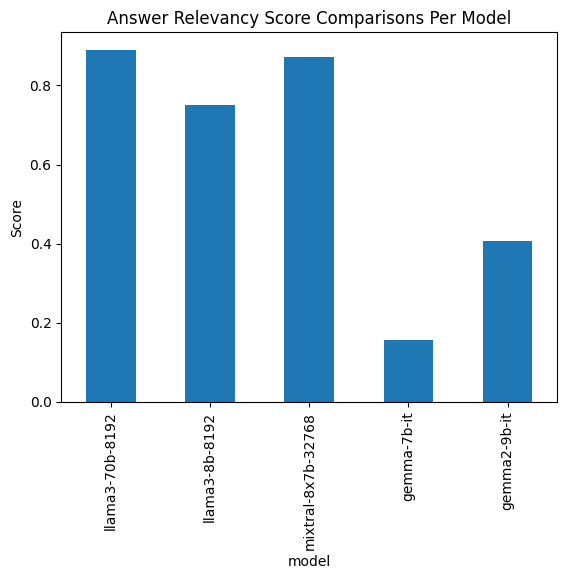

In [15]:
scores_df['answer_relevancy'].plot(kind='bar')
plt.title('Answer Relevancy Score Comparisons Per Model')
plt.ylabel('Score')
plt.show()

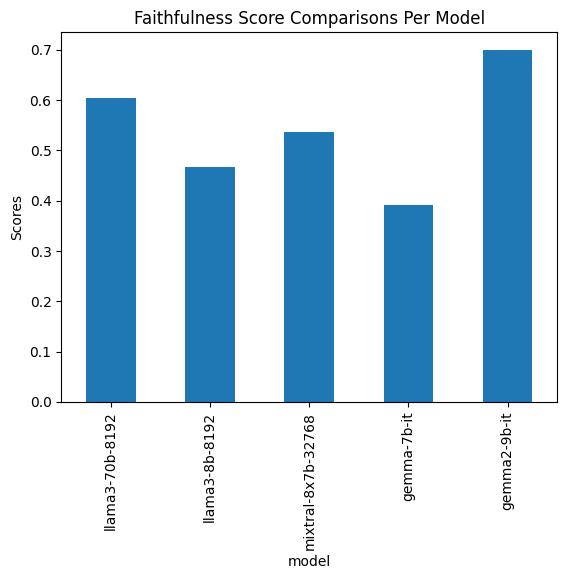

In [19]:
scores_df['faithfulness'].plot(kind='bar')
plt.title('Faithfulness Score Comparisons Per Model')
plt.ylabel('Scores')
plt.show()

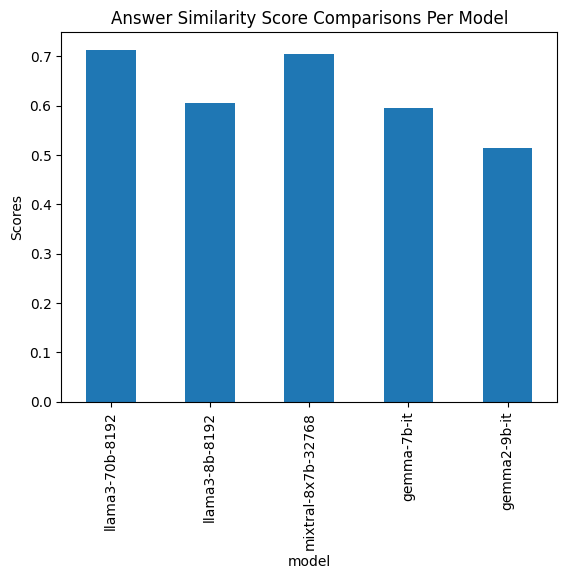

In [20]:
scores_df['answer_similarity'].plot(kind='bar')
plt.title('Answer Similarity Score Comparisons Per Model')
plt.ylabel('Scores')
plt.show()

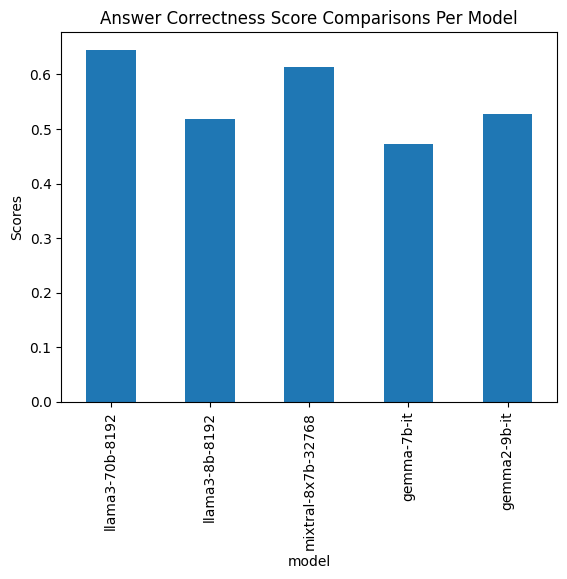

In [21]:
scores_df['answer_correctness'].plot(kind='bar')
plt.title('Answer Correctness Score Comparisons Per Model')
plt.ylabel('Scores')
plt.show()